In [1]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
from neo4j import GraphDatabase
from neo4j.exceptions import ServiceUnavailable
import re
import warnings 
warnings.filterwarnings('ignore')

# Import preprocessed data

In [2]:
## import preprocessed data
df = pd.read_csv(r'dataset\test_post_processed_result.csv')
for c in ['location','disease','keywords','organisation','country','country_code','lat,lng']:
    # print(c)
    df[c] = df[c].apply(lambda x:ast.literal_eval(x) )

df= df[df['title']!='error']

In [3]:
df

,link,title,body,summary,publish_date,location,disease,keywords,organisation,n_fatality,n_case,country,country_code,"lat,lng",infectious_score,distance_score,traveller_score
0,https://www.defensenews.com/land/2022/01/21/th...,"THAAD, in first operational use, destroys midr...",WASHINGTON — A multibillion-dollar missile def...,"The attack, which used cruise missiles, ballis...",2022-01-21 00:00:00,[],[],[],[HOUTHI],NaN,NaN,[],[],[],NaN,NaN,NaN
1,https://www.bbc.com/news/world-asia-60368498,Pakistan: Man accused of blasphemy killed by m...,The laws have been used to settle personal sco...,The laws have been used to settle personal sco...,NaN,"[PAKISTAN, KHANEWAL]",[],[case],[],NaN,NaN,"[Pakistan, Pakistan]","[PK, PK]","[(30.375321, 69.34511599999999), (30.286416, 7...",NaN,0.762177,0.045937
2,https://news.google.com/./articles/CBMiaWh0dHB...,US House speaker says lawmakers to move forwar...,WASHINGTON: US House of Representatives Speake...,WASHINGTON: US House of Representatives Speake...,NaN,[],[],[],"[US HOUSE, TIKTOK]",NaN,NaN,[],[],[],NaN,NaN,NaN
4,https://www.nknews.org/2022/01/north-korea-kic...,North Korea kicked off internet by suspected D...,North Korea disappeared from the internet for ...,North Korea disappeared from the internet for ...,2022-01-14 05:27:33+00:00,[NORTH KOREA],[],[],[DDOS],NaN,NaN,[North Korea],[KP],"[(40.339852, 127.510093)]",NaN,0.752508,0.188685
5,https://www.nbcnews.com/tech/security/nft-art-...,NFT art sales are booming. Just without some a...,Digital thieves had stolen from Aja Trier befo...,But thanks to the explosion of the NFT art mar...,NaN,[],[],[],[NFT],NaN,NaN,[],[],[],NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,https://news.google.com/./articles/CBMiSmh0dHB...,An unusual presentation of a rare disease: acu...,"Tropheryma whipplei, the causative organism in...",Whipple’s endocarditis is a rare disease in th...,2023-12-22 00:00:00,[],"[UPPER LIMB ISCHEMIA, WHIPPLE’S ENDOCARDITIS]","[infection, patient, symptom, case, disease, r...",[WHIPPLE’S ENDOCARDITIS],NaN,NaN,[],[],[],0.5,NaN,NaN
747,https://batonrougeclinic.com/are-more-people-g...,Are More People Getting These Diseases?,The prevalence of autoimmune diseases—conditio...,Autoimmune diseases are twice as likely to occ...,2022-02-28 15:05:37+00:00,[],[],"[case, symptom, disease]",[],NaN,NaN,[],[],[],NaN,NaN,NaN
748,https://www.neurologylive.com/view/disease-mod...,Disease-Modifying Therapies (DMT) and the Immu...,"Klaus Schmierer, MB BS, PhD, FRCP: Talking abo...","So there’s on the 1 hand, natalizumab, an anti...",NaN,[],[],"[infection, disease]",[THE IMMUNE SYSTEM],NaN,NaN,[],[],[],NaN,NaN,NaN
749,https://www.nbcnews.com/business/business-news...,Rising oil prices could affect thousands of pr...,American drivers were in for another unwelcome...,"Andrew Lipow, the president of Lipow Oil Assoc...",NaN,[],[],[],[],NaN,NaN,[],[],[],NaN,NaN,NaN


## Travelers Score Formula
$\alpha$ =  weightage of second hop

$S$ = visitor score

$s_x^c$ = Score of $x$ hop from country $c$ to SG 

$n$  = possible number of second hop country

$$S^c = {s_1^c + \alpha\frac{\sum_{1}^n{s_2^c}}{n}}$$


$$ Score = 1000 \times (DiseaseProb+\alpha RelevanceProd)$$ 
where, $\alpha$ = 0.5

# Clean Data

In [4]:
clean_df = pd.DataFrame()
clean_df['link'] = df['link']
clean_df['has_disease'] = df['disease'].apply(lambda x: int(len(x)>0))
# clean_df['keyword_count'] = df['keywords'].apply(lambda x: len(x))
clean_df['has_organisation'] = df['organisation'].apply(lambda x: len(x)>0)
clean_df['fatality_count'] = df['n_fatality'].fillna(0)
clean_df['case_count'] = df['n_fatality'].fillna(0)
clean_df['infectious_score'] = df['infectious_score'].fillna(0)
clean_df['traveller_score'] = df['traveller_score'].fillna(0)
clean_df['distance_score'] = df['distance_score'].fillna(0)
# dummy_keyword_df = pd.get_dummies(df.keywords.explode()).groupby(level=0).sum().add_prefix('keyword_')
# clean_df = pd.concat([clean_df, dummy_keyword_df],axis=1)
clean_df

,link,has_disease,has_organisation,fatality_count,case_count,infectious_score,traveller_score,distance_score
0,https://www.defensenews.com/land/2022/01/21/th...,0,True,0.0,0.0,0.0,0.000000,0.000000
1,https://www.bbc.com/news/world-asia-60368498,0,False,0.0,0.0,0.0,0.045937,0.762177
2,https://news.google.com/./articles/CBMiaWh0dHB...,0,True,0.0,0.0,0.0,0.000000,0.000000
4,https://www.nknews.org/2022/01/north-korea-kic...,0,True,0.0,0.0,0.0,0.188685,0.752508
5,https://www.nbcnews.com/tech/security/nft-art-...,0,True,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
745,https://news.google.com/./articles/CBMiSmh0dHB...,1,True,0.0,0.0,0.5,0.000000,0.000000
747,https://batonrougeclinic.com/are-more-people-g...,0,False,0.0,0.0,0.0,0.000000,0.000000
748,https://www.neurologylive.com/view/disease-mod...,0,True,0.0,0.0,0.0,0.000000,0.000000
749,https://www.nbcnews.com/business/business-news...,0,False,0.0,0.0,0.0,0.000000,0.000000


In [5]:
# all_keywords = dummy_keyword_df.columns.tolist()
# all_keywords

# Topic Classification

## Contextualized Embedding

In [6]:
# !pip install torch

In [7]:
import pickle
import torch
from scipy.spatial.distance import cosine
import numpy as np
from transformers import AutoTokenizer, TFAutoModel, pipeline


def get_topic_cls(series, model = 'PrebuildModel\ContextualisedEmbeding-SVM-Model.pkl'):
    topic_clf = pickle.load(open(model,'rb'))
    #using bert model and bert tokeniser for the embeddings
    model = TFAutoModel.from_pretrained('bert-base-uncased')
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    fe = pipeline('feature-extraction', model=model, tokenizer=tokenizer)
    title_embed = series.apply(lambda x: torch.mean(torch.tensor(np.squeeze(fe(x))), dim=0).numpy())
    return(topic_clf.predict_proba(title_embed.tolist())[:,1])
clean_df['disease_class_prob'] = get_topic_cls(df['title'])

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


# Load labelling

In [8]:
labeled_data = pd.read_csv('dataset\Google_compiled_01012023_23032023.csv')
labeled_data = labeled_data[['Relevant','Infectious_Disease','Research_disease','Rare_disease','Genetic_disease','Chronic_disease','link']]

In [9]:
clean_df['link']

0      https://www.defensenews.com/land/2022/01/21/th...
1           https://www.bbc.com/news/world-asia-60368498
2      https://news.google.com/./articles/CBMiaWh0dHB...
4      https://www.nknews.org/2022/01/north-korea-kic...
5      https://www.nbcnews.com/tech/security/nft-art-...
                             ...                        
745    https://news.google.com/./articles/CBMiSmh0dHB...
747    https://batonrougeclinic.com/are-more-people-g...
748    https://www.neurologylive.com/view/disease-mod...
749    https://www.nbcnews.com/business/business-news...
750    https://www.nbcnews.com/news/us-news/amys-kitc...
Name: link, Length: 743, dtype: object

In [10]:
labeled_data['link']

0      https://bmcgastroenterol.biomedcentral.com/art...
1      https://www.medicalnewstoday.com/articles/croh...
2      https://www.bbc.com/news/uk-england-northampto...
3      https://news.google.com/./articles/CBMidWh0dHB...
4      https://www.healthline.com/health/is-ibd-an-au...
                             ...                        
750    https://www.nbcnews.com/news/nbcblk/instagram-...
751    https://unctad.org/news/global-trade-hits-reco...
752    https://www.theguardian.com/media/2022/jan/19/...
753         https://news.un.org/en/story/2022/02/1110982
754    https://www.defensenews.com/global/europe/2022...
Name: link, Length: 755, dtype: object

In [11]:
labeled_df = clean_df.merge(labeled_data,left_on='link',right_on='link',how='left')
labeled_df

,link,has_disease,has_organisation,fatality_count,case_count,infectious_score,traveller_score,distance_score,disease_class_prob,Relevant,Infectious_Disease,Research_disease,Rare_disease,Genetic_disease,Chronic_disease
0,https://www.defensenews.com/land/2022/01/21/th...,0,True,0.0,0.0,0.0,0.000000,0.000000,0.052349,N,N,N,N,N,N
1,https://www.bbc.com/news/world-asia-60368498,0,False,0.0,0.0,0.0,0.045937,0.762177,0.058428,N,N,N,N,N,N
2,https://news.google.com/./articles/CBMiaWh0dHB...,0,True,0.0,0.0,0.0,0.000000,0.000000,0.069741,N,N,N,N,N,N
3,https://www.nknews.org/2022/01/north-korea-kic...,0,True,0.0,0.0,0.0,0.188685,0.752508,0.069755,N,N,N,N,N,N
4,https://www.nbcnews.com/tech/security/nft-art-...,0,True,0.0,0.0,0.0,0.000000,0.000000,0.069814,N,N,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,https://news.google.com/./articles/CBMiSmh0dHB...,1,True,0.0,0.0,0.5,0.000000,0.000000,0.812386,N,Y,N,N,N,N
743,https://batonrougeclinic.com/are-more-people-g...,0,False,0.0,0.0,0.0,0.000000,0.000000,0.925343,N,N,N,N,Y,N
744,https://www.neurologylive.com/view/disease-mod...,0,True,0.0,0.0,0.0,0.000000,0.000000,0.975112,N,N,Y,N,N,N
745,https://www.nbcnews.com/business/business-news...,0,False,0.0,0.0,0.0,0.000000,0.000000,0.069761,N,N,N,N,N,N


In [12]:
# labeled_df.to_csv(r'dataset\test_label_dataset.csv',index=False)

# Random forest

In [13]:
labeled_df = labeled_df[labeled_df['disease_class_prob'] >= 0.3]

## Dataset Split

In [14]:
x_col = ['has_disease', 'has_organisation', 'fatality_count',
       'case_count', 'infectious_score', 'traveller_score', 'distance_score'] + [c for c in labeled_df if 'keyword' in c]
y_col = 'Relevant'

X = labeled_df[x_col]
y = labeled_df[y_col]=='Y'

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score,recall_score

clf = RandomForestClassifier(n_estimators=60, random_state=0, max_features="sqrt")  
clf.fit(X_train, y_train)  
y_pred = clf.predict(X_test)  
print(classification_report(y_train,clf.predict(X_train)  ))  

              precision    recall  f1-score   support

       False       0.95      0.98      0.96       252
        True       0.91      0.75      0.82        56

    accuracy                           0.94       308
   macro avg       0.93      0.87      0.89       308
weighted avg       0.94      0.94      0.94       308



In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score,recall_score

print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
print(accuracy_score(y_test, y_pred))  

[[58  4]
 [ 6  9]]
              precision    recall  f1-score   support

       False       0.91      0.94      0.92        62
        True       0.69      0.60      0.64        15

    accuracy                           0.87        77
   macro avg       0.80      0.77      0.78        77
weighted avg       0.86      0.87      0.87        77

0.8701298701298701


In [17]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
RANDOM_STATE = 1
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features="sqrt",
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

RandomForestClassifier, max_features='sqrt'
RandomForestClassifier, max_features='log2'
RandomForestClassifier, max_features=None


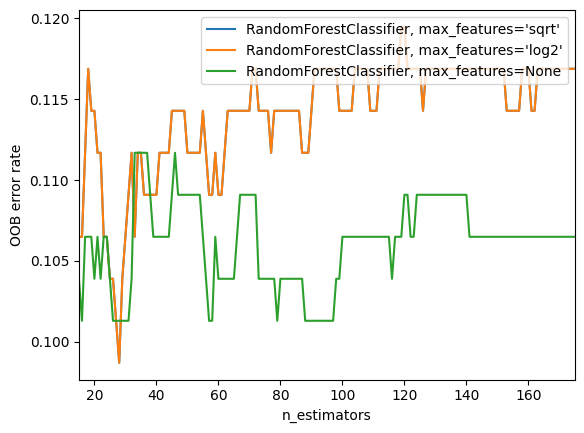

In [18]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
    
for label, clf_err in error_rate.items():
    print(label)
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)
    
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score,recall_score

clf = RandomForestClassifier(n_estimators=30, random_state=0, max_features="sqrt")  
clf.fit(X_train, y_train)  
y_pred = clf.predict(X_test)  
print(classification_report(y_train,clf.predict(X_train)  ))  

              precision    recall  f1-score   support

       False       0.95      0.98      0.96       252
        True       0.91      0.75      0.82        56

    accuracy                           0.94       308
   macro avg       0.93      0.87      0.89       308
weighted avg       0.94      0.94      0.94       308



In [20]:
pd.DataFrame({'feature':clf.feature_names_in_,'importance':clf.feature_importances_}).sort_values('importance',ascending=False)

,feature,importance
6,distance_score,0.417962
5,traveller_score,0.255721
2,fatality_count,0.099397
4,infectious_score,0.096254
3,case_count,0.081181
1,has_organisation,0.032042
0,has_disease,0.017442


## ROC

In [21]:
from sklearn import metrics
probs = clf.predict_proba(X_test)
y_test_dummies = pd.get_dummies(y_test.astype(str), drop_first=False).values
fpr, tpr, threshs = metrics.roc_curve(y_test, probs[:,1])
roc_auc = metrics.auc(fpr, tpr)

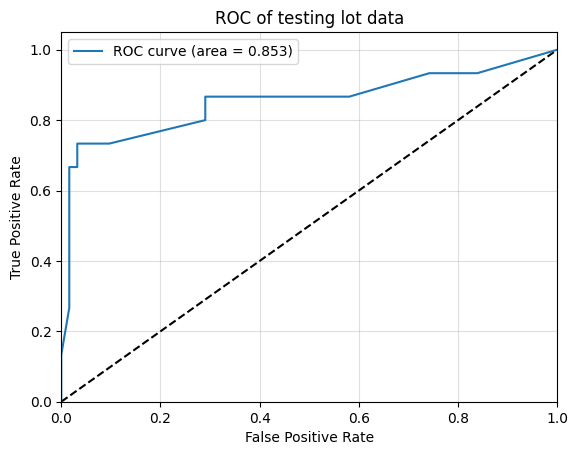

In [22]:
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC of testing lot data')
ax.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
ax.legend(loc="best")
ax.grid(alpha=.4)


In [23]:
precisions =[]
recalls =[]
indices = []
increment = 0.01
for i in range(0,100):
    threshold = i*increment
    predicted_proba = clf.predict_proba(X_test)
    predicted = (predicted_proba[:,1] >= threshold).astype('int')
    accuracy = accuracy_score(y_test, predicted)
    precisions.append(precision_score(y_test, predicted))
    recalls.append(recall_score(y_test, predicted))
    indices.append(threshold)

Text(0.5, 0, 'Prob')

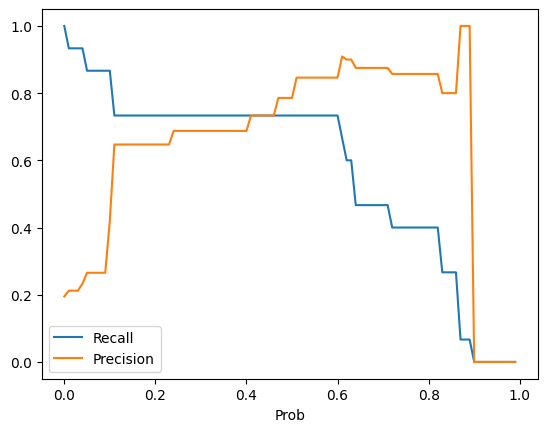

In [24]:
plt.plot(indices,recalls, label='Recall')
plt.plot(indices,precisions, label='Precision')
plt.legend()
plt.xlabel('Prob')

Good recall = ~0.8, 0,3 prob
 

In [25]:
threshold = 0.1
predicted_proba = clf.predict_proba(X_test)
predicted = (predicted_proba[:,1] >= threshold).astype('int')

print(confusion_matrix(y_test,predicted))  
print(classification_report(y_test,predicted))  

[[44 18]
 [ 2 13]]
              precision    recall  f1-score   support

       False       0.96      0.71      0.81        62
        True       0.42      0.87      0.57        15

    accuracy                           0.74        77
   macro avg       0.69      0.79      0.69        77
weighted avg       0.85      0.74      0.77        77



In [26]:
labeled_df['predited_prob'] = clf.predict_proba(X)[:,1]

In [35]:
pickle.dump(clf, open(r'PrebuildModel\relevance-rf-model.pkl','wb'))

In [28]:
# labeled_df.to_csv(r'dataset\test_scored_result.csv',index=False)

## Testing with 11 April Data

In [29]:
test_df = pd.read_csv(r'dataset\demo_post_processed_result.csv')

# convert columns type to list
for c in ['location','disease','keywords','organisation','country','country_code','lat,lng']:
    # print(c)
    test_df[c] = test_df[c].apply(lambda x:ast.literal_eval(x) )
test_df= test_df[test_df['title']!='error']

# preprocessing
clean_test_df = pd.DataFrame()
clean_test_df['link'] = test_df['link']
clean_test_df['has_disease'] = test_df['disease'].apply(lambda x: int(len(x)>0))
# clean_test_df['keyword_count'] = test_df['keywords'].apply(lambda x: len(x))
clean_test_df['has_organisation'] = test_df['organisation'].apply(lambda x: len(x)>0)
clean_test_df['fatality_count'] = test_df['n_fatality'].fillna(0)
clean_test_df['case_count'] = test_df['n_fatality'].fillna(0)
clean_test_df['infectious_score'] = test_df['infectious_score'].fillna(0)
clean_test_df['traveller_score'] = test_df['traveller_score'].fillna(0)
clean_test_df['distance_score'] = test_df['distance_score'].fillna(0)
# dummy_keyword_df = pd.get_dummies(test_df.keywords.explode()).groupby(level=0).sum().add_prefix('keyword_')
# clean_test_df = pd.concat([clean_test_df, dummy_keyword_df],axis=1)
# get other keyword column
# for c in list(set(all_keywords) - set(dummy_keyword_df.columns.tolist())):
#     clean_test_df[c] = 0
clean_test_df['disease_class_prob'] = get_topic_cls(test_df['title'])
clean_test_df

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


,link,has_disease,has_organisation,fatality_count,case_count,infectious_score,traveller_score,distance_score,disease_class_prob
0,https://www.channelnewsasia.com/business/tsmcs...,0,True,0.0,0.0,0.0,0.178542,0.845211,0.061918
1,https://www.straitstimes.com/asia/se-asia/us-p...,0,False,0.0,0.0,0.0,0.268197,0.558840,0.045196
2,https://www.straitstimes.com/life/arts/hum-the...,0,True,0.0,0.0,0.0,0.000000,0.000000,0.038372
3,https://www.channelnewsasia.com/sport/inters-s...,0,True,0.0,0.0,0.0,0.157908,0.500000,0.003292
4,https://www.straitstimes.com/business/cards-ar...,0,False,0.0,0.0,0.0,1.000000,1.000000,0.007864
...,...,...,...,...,...,...,...,...,...
275,https://www.channelnewsasia.com/asia/taiwan-de...,0,False,0.0,0.0,0.0,0.178542,0.845211,0.019313
276,https://www.straitstimes.com/life/motoring/car...,0,False,0.0,0.0,0.0,0.000000,0.000000,0.045253
277,https://www.channelnewsasia.com/commentary/rus...,0,False,0.0,0.0,0.0,0.119637,0.582700,0.083397
278,https://www.malaymail.com/news/money/2023/04/1...,0,False,0.0,0.0,0.0,0.000000,0.000000,0.086054


In [30]:
unseen_x = clean_test_df[x_col]
unseen_x

,has_disease,has_organisation,fatality_count,case_count,infectious_score,traveller_score,distance_score
0,0,True,0.0,0.0,0.0,0.178542,0.845211
1,0,False,0.0,0.0,0.0,0.268197,0.558840
2,0,True,0.0,0.0,0.0,0.000000,0.000000
3,0,True,0.0,0.0,0.0,0.157908,0.500000
4,0,False,0.0,0.0,0.0,1.000000,1.000000
...,...,...,...,...,...,...,...
275,0,False,0.0,0.0,0.0,0.178542,0.845211
276,0,False,0.0,0.0,0.0,0.000000,0.000000
277,0,False,0.0,0.0,0.0,0.119637,0.582700
278,0,False,0.0,0.0,0.0,0.000000,0.000000


In [31]:
test_df['prob']=clf.predict_proba(unseen_x)[:,1]*500 + clean_test_df['disease_class_prob']*1000

In [32]:
test_df.sort_values('prob',ascending=False)[['title','prob']].head(20).reset_index()

,index,title,prob
0,18,First H3N8 bird flu death recorded in China,1082.310558
1,261,Rising COVID-19 cases in Singapore driven by X...,1054.481192
2,146,Wildfire in South Korea forces 500 residents t...,703.924324
3,9,China’s sandstorm problem spreads to South Kor...,581.412595
4,50,South Korea wildfire forces 500 residents to e...,563.158092
5,102,4 South-east Asian women held captive by sex t...,538.630680
6,264,‘Revenge of the geeks’: Drones battle on Ukrai...,537.345187
7,250,"At Mexico's Chichen Itza, archaeologists disco...",526.282034
8,63,IMF says more flexible BOJ yield control can p...,517.650783
9,87,US stocks mixed as markets try to shrug off do...,490.193306


In [33]:
test_df.sort_values('prob',ascending=False)['title'].head(15)

18           First H3N8 bird flu death recorded in China
261    Rising COVID-19 cases in Singapore driven by X...
146    Wildfire in South Korea forces 500 residents t...
9      China’s sandstorm problem spreads to South Kor...
50     South Korea wildfire forces 500 residents to e...
102    4 South-east Asian women held captive by sex t...
264    ‘Revenge of the geeks’: Drones battle on Ukrai...
250    At Mexico's Chichen Itza, archaeologists disco...
63     IMF says more flexible BOJ yield control can p...
87     US stocks mixed as markets try to shrug off do...
233                    Today in Pictures, April 12, 2023
155    Alibaba to roll out generative AI across apps,...
178    North Korea parade ‘probably oversells’ ICBM t...
121    Swiss researchers use typing, mouse clicks to ...
125    Eleven International Wins Prestigious Gold Ste...
Name: title, dtype: object

In [34]:
test_df.sort_values('prob',ascending=False)

,link,title,body,summary,publish_date,location,disease,keywords,organisation,n_fatality,n_case,country,country_code,"lat,lng",infectious_score,distance_score,traveller_score,prob
18,https://www.channelnewsasia.com/asia/first-bir...,First H3N8 bird flu death recorded in China,GENEVA: A woman has died from H3N8 bird flu in...,GENEVA: A woman has died from H3N8 bird flu in...,NaN,[CHINA],[BIRD FLU],"[death, case, health, report, flu]",[],NaN,NaN,[China],[CN],"[(35.86166, 104.195397)]",0.5,0.808126,1.187598,1082.310558
261,https://www.channelnewsasia.com/singapore/covi...,Rising COVID-19 cases in Singapore driven by X...,CLINICS SEEING MORE CASES\n\nClinics are also ...,CLINICS SEEING MORE CASESClinics are also seei...,NaN,[SINGAPORE],[COVID-19],"[patient, case, symptom, infection, report]","[XBB, MOH]",NaN,NaN,[Singapore],[SG],"[(1.352083, 103.819836)]",1.0,1.000000,1.000000,1054.481192
146,https://www.straitstimes.com/asia/east-asia/so...,Wildfire in South Korea forces 500 residents t...,SEOUL – More than 500 people evacuated their h...,SEOUL – More than 500 people evacuated their h...,2023-04-11 12:47:45+08:00,"[WILDFIRE, SOUTH KOREA]",[],[spread],[],NaN,NaN,"[unknown, South Korea]","[unknown, KR]","[(0, 0), (35.907757, 127.766922)]",NaN,0.635822,0.214128,703.924324
9,https://www.straitstimes.com/asia/east-asia/sa...,China’s sandstorm problem spreads to South Kor...,BEIJING - Severe sandstorms that have been pla...,BEIJING - Severe sandstorms that have been pla...,2023-04-11 09:54:32+08:00,"[CHINA, SOUTH KOREA, JAPAN]",[],"[health, spread]",[],NaN,NaN,"[China, South Korea, Japan]","[CN, KR, JP]","[(35.86166, 104.195397), (35.907757, 127.76692...",NaN,0.772427,0.588504,581.412595
50,https://www.channelnewsasia.com/asia/south-kor...,South Korea wildfire forces 500 residents to e...,SEOUL: More than 500 people evacuated from the...,SEOUL: More than 500 people evacuated from the...,NaN,[SOUTH KOREA],[],"[spread, report]",[],NaN,NaN,[South Korea],[KR],"[(35.907757, 127.766922)]",NaN,0.771645,0.270349,563.158092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,https://www.malaymail.com/news/sports/2023/04/...,"Djokovic labours to win, Tsitsipas advances in...","MONTE CARLO, April 12 — Novak Djokovic made a ...","MONTE CARLO, April 12 — Novak Djokovic made a ...",12/4/2023 0:00,[],[],[],[TSITSIPAS],NaN,NaN,[],[],[],NaN,NaN,NaN,3.094277
248,https://www.straitstimes.com/sport/football/ch...,Chelsea happy to be underdogs against Real Mad...,MADRID - Chelsea are looking forward to the ch...,MADRID - Chelsea are looking forward to the ch...,2023-04-12 04:19:29+08:00,[],[],[],"[CHELSEA, REAL MADRID]",NaN,NaN,[],[],[],NaN,NaN,NaN,2.160034
181,https://www.channelnewsasia.com/sport/surfing-...,Surfing-Home hero Ewing emulates late mum by w...,MELBOURNE : Australian surfer Ethan Ewing foll...,MELBOURNE : Australian surfer Ethan Ewing foll...,NaN,[],[],[],[SURFING-HOME],NaN,NaN,[],[],[],NaN,NaN,NaN,1.995000
111,https://www.straitstimes.com/sport/football/fr...,Frank Lampard urges Chelsea to emulate 2012 sh...,LONDON – Frank Lampard has urged Chelsea to ig...,LONDON – Frank Lampard has urged Chelsea to ig...,2023-04-11 18:38:10+08:00,[],[],[],[CHELSEA],NaN,NaN,[],[],[],NaN,NaN,NaN,1.866621
